In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dfppl = pd.read_pickle('../data_intermediate/profile_cleaned.pkl')
dfinfo = pd.read_pickle('../data_intermediate/transactions.pkl')

dfportfo = pd.read_pickle('../data_intermediate/portfolio.pkl')

In [3]:
# Show a sample of people data
dfppl.sample(10, random_state = 3)

,gender,person_id,member_year,age,income_thousand
15166,F,c19daa02,2018,56.0,51.0
281,F,2c3a4de6,2017,30.0,40.0
13444,M,c87e0177,2017,52.0,98.0
4201,NaN,0011e0d4,2018,40.0,57.0
1343,F,decbcf83,2017,78.0,89.0
14407,M,bbaca981,2014,39.0,46.0
7153,F,b03e8502,2017,84.0,87.0
1175,F,54dd0ebf,2017,20.0,39.0
6596,M,8fda2481,2015,65.0,38.0
11895,None,19fc24db,2016,NaN,NaN


In [4]:
# Show a sample of transactions data
##This is already merged with information about offers
dfinfo.sample(10, random_state = 1)

,event,person_id,offer_id,reward_amt,purchase_amt,reward_offer,channels,difficulty,duration,offer_type,day_month
239823,no offer,1852fd4c,xxxxxx,0,2.80,NaN,NaN,NaN,NaN,NaN,24
148695,no offer,5532539d,xxxxxx,0,19.08,NaN,NaN,NaN,NaN,NaN,17
302969,offer completed,86991c80,2298d6,3,0.00,3.0,emsw,7.0,7.0,discount,30
128881,offer viewed,1929135b,4d5c57,0,0.00,10.0,emsw,10.0,5.0,bogo,15
222794,offer viewed,58566614,9b98b8,0,0.00,5.0,emw,5.0,7.0,bogo,22
103947,no offer,3723ab43,xxxxxx,0,3.44,NaN,NaN,NaN,NaN,NaN,13
5930,offer received,954b2140,2298d6,0,0.00,3.0,emsw,7.0,7.0,discount,1
119762,offer received,7aabd3e6,f19421,0,0.00,5.0,emsw,5.0,5.0,bogo,15
276603,no offer,ef8f6714,xxxxxx,0,22.43,NaN,NaN,NaN,NaN,NaN,26
95702,no offer,efef288a,xxxxxx,0,4.11,NaN,NaN,NaN,NaN,NaN,11


In [5]:
# Merge the two datasets: transactions & people 
dfinfo = pd.merge(dfinfo, dfppl, on= 'person_id', how= 'left', sort= False)

### Day of Month

<AxesSubplot:>

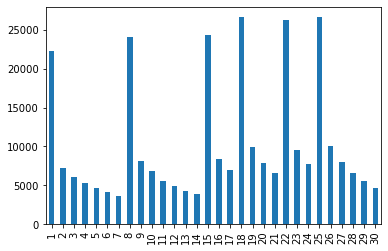

In [6]:
dfinfo['day_month'].value_counts().sort_index().plot.bar()

In [7]:
# I'll keep these transactions as test
dfinfo.loc[dfinfo['day_month'] >= 25].shape

(61412, 15)

In [8]:
# I'll use these transactions as training
dfinfo.loc[dfinfo['day_month'] < 25].shape

(245122, 15)

In [9]:
dfinfo = dfinfo.loc[dfinfo['day_month'] < 25]

In [10]:
dfinfo['event'].value_counts()

no offer           108421
offer received      63512
offer viewed        47411
offer completed     25778
Name: event, dtype: int64

<AxesSubplot:>

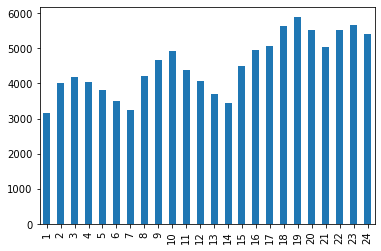

In [11]:
dfinfo.loc[dfinfo['event'] == 'no offer', 'day_month'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

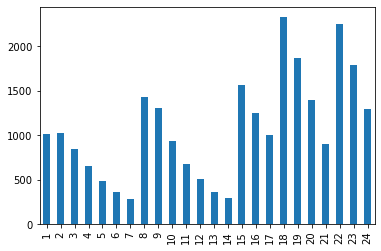

In [12]:
dfinfo.loc[dfinfo['event'].str.contains('completed'), 'day_month'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

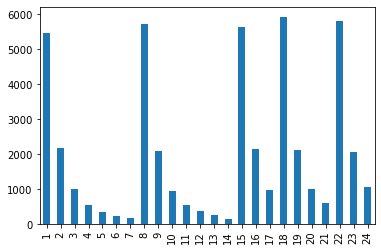

In [13]:
dfinfo.loc[dfinfo['event'].str.contains('viewed'), 'day_month'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

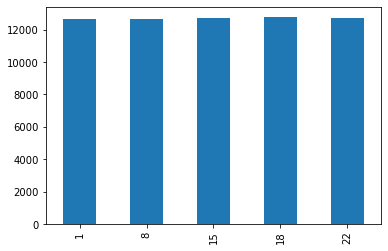

In [14]:
dfinfo.loc[dfinfo['event'].str.contains('received'), 'day_month'].value_counts().sort_index().plot.bar()

Observing the plots, I gather that every 7 days a _wave_ of promotional offers is sent to people. However, most of the action happens at the first day, and the next two days after.
So, perhaps it's better to make wave every 3 days or twice a week. An A/B experiment could be to compare these two scenarios together. Especially you can see this when promotional offers is sent 3 days after day 18, same actions - i.e., completing the offer - happens. 

### Gender

In [15]:
def make_pivot_table(df, idx, col):
    """A helper function to make frequency table.
    
    Arguments
    --------------
    df {dataframe}
    idx {index/row}
    col {column variable}
    
    Returns
    --------------
    Rowwise normalized frequency table
    """
    res = pd.crosstab(df[idx], df[col], dropna= False).apply(lambda r: r/r.sum(), axis=1)
    return res.round(2) 

In [16]:
make_pivot_table(dfinfo, 'gender', 'event')

event,no offer,offer completed,offer received,offer viewed
gender,,,,
F,0.43,0.13,0.25,0.19
M,0.46,0.10,0.26,0.19


Here, we can see that women tend to complete the offers more. But men tend to purchase more even without a promo. So, more promo offers for women than men?

In [17]:
make_pivot_table(dfinfo.loc[dfinfo['offer_type'] == 'discount'], 'gender', 'event')

event,offer completed,offer received,offer viewed
gender,,,
F,0.28,0.42,0.29
M,0.24,0.46,0.31


In [18]:
make_pivot_table(dfinfo.loc[dfinfo['offer_type'] == 'bogo'], 'gender', 'event')

event,offer completed,offer received,offer viewed
gender,,,
F,0.26,0.41,0.33
M,0.20,0.44,0.36


As we see, the conversion rate for `discount` offer is more than that of `bogo` for both genders. Especially, __men__ tend to prefer the __discount__: as you could see eventhough higher percentage of men _view_ the received bogo promo, as opposed to the discount, it's just not interesting enough for them.   

On the other hand, the preference of discount over bogo offer for women is not that stark. So, perhaps, we could send more bogo to women and more discount to men? This could be really interesting source of insight if combined with other demographic data, like if we get their facebook data. 

### Offer Type

Here, I'm comparing two `discount` offer that are interestingly different. Basically I'm going to see how influential are __duration__, __difficulty__, and the offered __reward__ for discount offers. So, in the following table, we see that for one offer we need to spend at least 7USD, and the reward is 3USD. Interestingly, the latter requires 10USD purchase, for a reward of 2USD.

In [19]:
ids_discount = ['2298d6', 'fafdcd']
dfportfo.loc[dfportfo['offer_id'].isin(ids_discount)]

,reward_offer,channels,difficulty,duration,offer_type,offer_id
5,3,emsw,7,7,discount,2298d6
6,2,emsw,10,10,discount,fafdcd


In [23]:
# Subset the data to only have those offer_ids of interest
df = dfinfo.loc[dfinfo['offer_id'].isin(ids_discount)]
# Make the frequency plot for it
make_pivot_table(df, 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
2298d6,0.24,0.39,0.37
fafdcd,0.25,0.39,0.37


In [25]:
# And if we get deeper, and only analyze the men we have:
make_pivot_table(df.loc[df['gender'] == 'M'], 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
2298d6,0.24,0.39,0.37
fafdcd,0.25,0.39,0.37


We've already established that men prefer discount more (than bogo). Here, we notice that __difficulty__ is not that much important. 

Similarly, let's investigate two `bogo` offer that are different only in __difficulty__ and __reward__. Basically, one is more expensive than another. You can see the information in table bellow.

In [27]:
# Subset data for the following two ids for bogo offers
ids_bogo = ['4d5c57', 'f19421']
dfportfo.loc[dfportfo['offer_id'].isin(ids_bogo)]

,reward_offer,channels,difficulty,duration,offer_type,offer_id
1,10,emsw,10,5,bogo,4d5c57
8,5,emsw,5,5,bogo,f19421


In [28]:
df2 = dfinfo.loc[dfinfo['offer_id'].isin(ids_bogo)]

make_pivot_table(df2, 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
4d5c57,0.18,0.42,0.40
f19421,0.22,0.40,0.38


In [29]:
make_pivot_table(df2.loc[df2['gender'] == 'F'], 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
4d5c57,0.24,0.39,0.37
f19421,0.25,0.38,0.36


In [30]:
make_pivot_table(df2.loc[df2['gender'] == 'M'], 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
4d5c57,0.16,0.43,0.41
f19421,0.22,0.40,0.38


Here, we see that men tend to complete more bogo offers that are less difficult (cheaper?), although they are with less reward as well. Women's tendency is not that much distinct though.

### Income

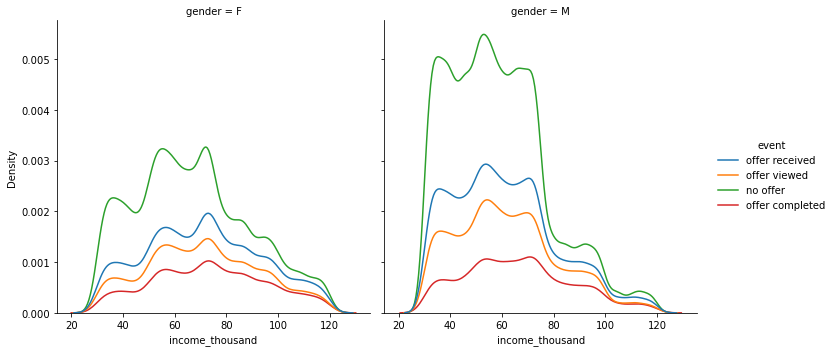

In [31]:
# Make a density plot breaken down by `gender` and `event`
sns.displot(dfinfo, x="income_thousand", hue="event", col="gender", kind="kde")

In [32]:
make_pivot_table(df2.loc[(df2['gender'] == 'M') & (df2['income_thousand'] < 80)], 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
4d5c57,0.14,0.44,0.42
f19421,0.21,0.41,0.39


In [33]:
make_pivot_table(df2.loc[(df2['gender'] == 'M') & (df2['income_thousand'] >= 80)], 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
4d5c57,0.26,0.38,0.36
f19421,0.26,0.38,0.36


In [34]:
make_pivot_table(df2.loc[(df2['gender'] == 'F') & (df2['income_thousand'] < 80)], 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
4d5c57,0.22,0.40,0.38
f19421,0.25,0.39,0.37


In [35]:
make_pivot_table(df2.loc[(df2['gender'] == 'F') & (df2['income_thousand'] >= 80)], 'offer_id', 'event')

event,offer completed,offer received,offer viewed
offer_id,,,
4d5c57,0.27,0.38,0.36
f19421,0.27,0.37,0.36


This confirms that, most of the interest for cheaper bogo (less difficulty) comes from those who earn less than 80K per year.